# 通过Sub-Pixel实现图像超分辨率
**作者:** [Ralph LU](https://github.com/ralph0813)<br>
**日期:** 2021.06 <br>
**摘要:** 本示例通过Sub-Pixel实现图像超分辨率。

## 一、简要介绍

在计算机视觉中，图像超分辨率（Image Super Resolution）是指由一幅低分辨率图像或图像序列恢复出高分辨率图像。图像超分辨率技术分为超分辨率复原和超分辨率重建。

本示例简要介绍如何通过飞桨开源框架，实现图像超分辨率。包括数据集的定义、模型的搭建与训练。

参考论文：《Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network》

论文链接：https://arxiv.org/abs/1609.05158

## 二、环境设置
导入一些比较基础常用的模块，确认自己的飞桨版本。

In [1]:
import os
import io
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from IPython.display import display

import paddle
from paddle.io import Dataset
from paddle.vision.transforms import transforms

print(paddle.__version__)

2.1.1


## 三、数据集
### 3.1 数据集下载
本案例使用BSR_bsds500数据集，下载链接：http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz

In [3]:
!wget --no-check-certificate --no-cookies --header "Cookie: oraclelicense=accept-securebackup-cookie" http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
!tar -zxvf BSR_bsds500.tgz

--2021-07-01 11:12:12--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1, 2620:12a:8000::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... failed: Connection timed out.
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|2620:12a:8001::1|:80... failed: Network is unreachable.
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|2620:12a:8000::1|:80... failed: Network is unreachable.
BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc

BSR/BSDS500/data/groundTruth/train/35091.mat
BSR/BSDS500/data/groundTruth/train/309004.mat
BSR/BSDS500/data/groundTruth/train/299091.mat
BSR/BSDS500/data/groundTruth/train/151087.mat
BSR/BSDS500/data/groundTruth/train/155060.mat
BSR/BSDS500/data/groundTruth/train/144067.mat
BSR/BSDS500/data/groundTruth/train/374067.mat
BSR/BSDS500/data/groundTruth/train/189003.mat
BSR/BSDS500/data/groundTruth/train/188091.mat
BSR/BSDS500/data/groundTruth/train/153077.mat
BSR/BSDS500/data/groundTruth/train/76002.mat
BSR/BSDS500/data/groundTruth/train/277095.mat
BSR/BSDS500/data/groundTruth/train/207056.mat
BSR/BSDS500/data/groundTruth/train/286092.mat
BSR/BSDS500/data/groundTruth/train/145053.mat
BSR/BSDS500/data/groundTruth/train/157036.mat
BSR/BSDS500/data/groundTruth/train/138032.mat
BSR/BSDS500/data/groundTruth/train/242078.mat
BSR/BSDS500/data/groundTruth/train/176039.mat
BSR/BSDS500/data/groundTruth/train/163014.mat
BSR/BSDS500/data/groundTruth/train/376020.mat
BSR/BSDS500/data/groundTruth/train/1

BSR/BSDS500/data/groundTruth/val/210088.mat
BSR/BSDS500/data/groundTruth/val/304034.mat
BSR/BSDS500/data/groundTruth/val/271035.mat
BSR/BSDS500/data/groundTruth/val/78004.mat
BSR/BSDS500/data/groundTruth/val/163085.mat
BSR/BSDS500/data/groundTruth/val/236037.mat
BSR/BSDS500/data/groundTruth/val/38092.mat
BSR/BSDS500/data/groundTruth/val/66053.mat
BSR/BSDS500/data/groundTruth/val/55073.mat
BSR/BSDS500/data/groundTruth/val/19021.mat
BSR/BSDS500/data/groundTruth/val/86016.mat
BSR/BSDS500/data/groundTruth/val/253027.mat
BSR/BSDS500/data/groundTruth/val/159008.mat
BSR/BSDS500/data/groundTruth/val/41033.mat
BSR/BSDS500/data/groundTruth/val/8023.mat
BSR/BSDS500/data/groundTruth/val/37073.mat
BSR/BSDS500/data/groundTruth/val/296007.mat
BSR/BSDS500/data/groundTruth/val/306005.mat
BSR/BSDS500/data/groundTruth/test/
BSR/BSDS500/data/groundTruth/test/70090.mat
BSR/BSDS500/data/groundTruth/test/41085.mat
BSR/BSDS500/data/groundTruth/test/196062.mat
BSR/BSDS500/data/groundTruth/test/346016.mat
BSR/B

BSR/BSDS500/data/groundTruth/test/107045.mat
BSR/BSDS500/data/groundTruth/test/217090.mat
BSR/BSDS500/data/groundTruth/test/94095.mat
BSR/BSDS500/data/groundTruth/test/365072.mat
BSR/BSDS500/data/groundTruth/test/226022.mat
BSR/BSDS500/data/groundTruth/test/188025.mat
BSR/BSDS500/data/groundTruth/test/147080.mat
BSR/BSDS500/data/groundTruth/test/120093.mat
BSR/BSDS500/data/groundTruth/test/376086.mat
BSR/BSDS500/data/groundTruth/test/100039.mat
BSR/BSDS500/data/groundTruth/test/159022.mat
BSR/BSDS500/data/groundTruth/test/384089.mat
BSR/BSDS500/data/groundTruth/test/189096.mat
BSR/BSDS500/data/groundTruth/test/108069.mat
BSR/BSDS500/data/groundTruth/test/118072.mat
BSR/BSDS500/data/groundTruth/test/29030.mat
BSR/BSDS500/data/groundTruth/test/107014.mat
BSR/BSDS500/data/groundTruth/test/164046.mat
BSR/BSDS500/data/groundTruth/test/108004.mat
BSR/BSDS500/data/groundTruth/test/140006.mat
BSR/BSDS500/data/groundTruth/test/202000.mat
BSR/BSDS500/data/groundTruth/test/207049.mat
BSR/BSDS500/

BSR/BSDS500/data/images/train/145014.jpg
BSR/BSDS500/data/images/train/202012.jpg
BSR/BSDS500/data/images/train/109034.jpg
BSR/BSDS500/data/images/train/8143.jpg
BSR/BSDS500/data/images/train/271008.jpg
BSR/BSDS500/data/images/train/157036.jpg
BSR/BSDS500/data/images/train/33066.jpg
BSR/BSDS500/data/images/train/353013.jpg
BSR/BSDS500/data/images/train/78019.jpg
BSR/BSDS500/data/images/train/231015.jpg
BSR/BSDS500/data/images/train/26031.jpg
BSR/BSDS500/data/images/train/227040.jpg
BSR/BSDS500/data/images/train/198004.jpg
BSR/BSDS500/data/images/train/365073.jpg
BSR/BSDS500/data/images/train/161062.jpg
BSR/BSDS500/data/images/train/105019.jpg
BSR/BSDS500/data/images/train/216053.jpg
BSR/BSDS500/data/images/train/35091.jpg
BSR/BSDS500/data/images/train/126039.jpg
BSR/BSDS500/data/images/train/216041.jpg
BSR/BSDS500/data/images/train/187071.jpg
BSR/BSDS500/data/images/train/76002.jpg
BSR/BSDS500/data/images/train/42044.jpg
BSR/BSDS500/data/images/train/65010.jpg
BSR/BSDS500/data/images/t

BSR/BSDS500/data/images/test/168084.jpg
BSR/BSDS500/data/images/test/393035.jpg
BSR/BSDS500/data/images/test/226060.jpg
BSR/BSDS500/data/images/test/147077.jpg
BSR/BSDS500/data/images/test/145059.jpg
BSR/BSDS500/data/images/test/388006.jpg
BSR/BSDS500/data/images/test/141012.jpg
BSR/BSDS500/data/images/test/317043.jpg
BSR/BSDS500/data/images/test/267036.jpg
BSR/BSDS500/data/images/test/118031.jpg
BSR/BSDS500/data/images/test/140006.jpg
BSR/BSDS500/data/images/test/230063.jpg
BSR/BSDS500/data/images/test/279005.jpg
BSR/BSDS500/data/images/test/87015.jpg
BSR/BSDS500/data/images/test/123057.jpg
BSR/BSDS500/data/images/test/388067.jpg
BSR/BSDS500/data/images/test/70090.jpg
BSR/BSDS500/data/images/test/48025.jpg
BSR/BSDS500/data/images/test/246009.jpg
BSR/BSDS500/data/images/test/130066.jpg
BSR/BSDS500/data/images/test/117025.jpg
BSR/BSDS500/data/images/test/160006.jpg
BSR/BSDS500/data/images/test/201080.jpg
BSR/BSDS500/data/images/test/120003.jpg
BSR/BSDS500/data/images/test/80085.jpg
BSR/



### 3.2 数据集概览
```
BSR
├── BSDS500
│   └── data
│       ├── groundTruth
│       │   ├── test
│       │   ├── train
│       │   └── val
│       └── images
│           ├── test
│           ├── train
│           └── val
├── bench
│   ├── benchmarks
│   ├── data
│   │   ├── ...
│   │   └── ...
│   └── source
└── documentation
```

可以看到需要的图片文件在BSR/BSDS500/images文件夹下，train、test各200张，val为100张。

### 3.3 数据集类定义
飞桨（PaddlePaddle）数据集加载方案是统一使用Dataset（数据集定义） + DataLoader（多进程数据集加载）。

首先先进行数据集的定义，数据集定义主要是实现一个新的Dataset类，继承父类paddle.io.Dataset，并实现父类中以下两个抽象方法，__getitem__和__len__：
```python
class MyDataset(Dataset):
    def __init__(self):
        ...

    # 每次迭代时返回数据和对应的标签
    def __getitem__(self, idx):
        return x, y

    # 返回整个数据集的总数
    def __len__(self):
        return count(samples)
```


In [4]:
class BSD_data(Dataset):
    """
    继承paddle.io.Dataset类
    """
    def __init__(self, mode='train',image_path="BSR/BSDS500/data/images/"):
        """
        实现构造函数，定义数据读取方式，划分训练和测试数据集
        """
        super(BSD_data, self).__init__()
        
        self.mode = mode.lower()
        if self.mode == 'train':
            self.image_path = os.path.join(image_path,'train')
        elif self.mode == 'val':
            self.image_path = os.path.join(image_path,'val')
        else:
            raise ValueError('mode must be "train" or "val"')
            
        # 原始图像的缩放大小
        self.crop_size = 300
        # 缩放倍率
        self.upscale_factor = 3
        # 缩小后送入神经网络的大小
        self.input_size = self.crop_size // self.upscale_factor
        # numpy随机数种子
        self.seed=1337
        # 图片集合
        self.temp_images = []
        # 加载数据
        self._parse_dataset()
    
    def transforms(self, img):
        """
        图像预处理工具，用于将升维(100, 100) => (100, 100,1)，
        并对图像的维度进行转换从HWC变为CHW
        """
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=2)
        return img.transpose((2, 0, 1))
        
    def __getitem__(self, idx):
        """
        返回 缩小3倍后的图片 和 原始图片
        """
        
        # 加载原始图像
        img = self._load_img(self.temp_images[idx])
        # 将原始图像缩放到（3, 300, 300）
        img = img.resize([self.crop_size,self.crop_size], Image.BICUBIC)

        #转换为YCbCr图像
        ycbcr = img.convert("YCbCr")

        # 因为人眼对亮度敏感，所以只取Y通道
        y, cb, cr = ycbcr.split()
        y = np.asarray(y,dtype='float32')
        y = y / 255.0

        # 缩放后的图像和前面采取一样的操作
        img_ = img.resize([self.input_size,self.input_size], Image.BICUBIC)
        ycbcr_ = img_.convert("YCbCr")
        y_, cb_, cr_ = ycbcr_.split()
        y_ = np.asarray(y_,dtype='float32')
        y_ = y_ / 255.0

        # 升纬并将HWC转换为CHW
        y = self.transforms(y)
        x = self.transforms(y_)

        # x为缩小3倍后的图片（1, 100, 100） y是原始图片（1, 300, 300）
        return x, y


    def __len__(self):
        """
        实现__len__方法，返回数据集总数目
        """
        return len(self.temp_images)
    
    def _sort_images(self, img_dir):
        """
        对文件夹内的图像进行按照文件名排序
        """
        files = []

        for item in os.listdir(img_dir):
            if item.split('.')[-1].lower() in ["jpg",'jpeg','png']:
                files.append(os.path.join(img_dir, item))

        return sorted(files)
    
    def _parse_dataset(self):
        """
        处理数据集
        """
        self.temp_images = self._sort_images(self.image_path)
        random.Random(self.seed).shuffle(self.temp_images)
        
    def _load_img(self, path):
        """
        从磁盘读取图片
        """
        with open(path, 'rb') as f:
            img = Image.open(io.BytesIO(f.read()))
            img = img.convert('RGB')
            return img

### 3.4 PetDataSet数据集抽样展示
实现好BSD_data数据集后，我们来测试一下数据集是否符合预期，因为BSD_data是一个可以被迭代的Class，我们通过for循环从里面读取数据进行展示。

=============train dataset=============


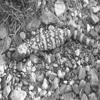

(100, 100)

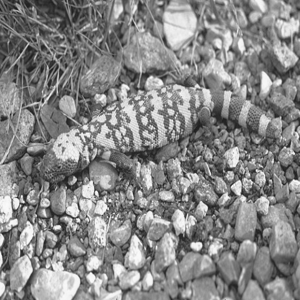

(300, 300)

In [5]:
# 测试定义的数据集
train_dataset = BSD_data(mode='train')
val_dataset = BSD_data(mode='val')

print('=============train dataset=============')
x, y = train_dataset[0]
x = x[0]
y = y[0]
x = x * 255
y = y * 255
img_ = Image.fromarray(np.uint8(x), mode="L")
img = Image.fromarray(np.uint8(y), mode="L")
display(img_)
display(img_.size)
display(img)
display(img.size)

## 四、模型组网
Sub_Pixel_CNN是一个全卷积网络，网络结构比较简单，这里采用Layer类继承方式组网。

In [6]:
class Sub_Pixel_CNN(paddle.nn.Layer):

    def __init__(self, upscale_factor=3, channels=1):
        super(Sub_Pixel_CNN, self).__init__()
        
        self.conv1 = paddle.nn.Conv2D(channels,64,5,stride=1, padding=2)
        self.conv2 = paddle.nn.Conv2D(64,64,3,stride=1, padding=1)
        self.conv3 = paddle.nn.Conv2D(64,32,3,stride=1, padding=1)
        self.conv4 = paddle.nn.Conv2D(32,channels * (upscale_factor ** 2),3,stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = paddle.nn.functional.pixel_shuffle(x,3)
        return x

### 4.1 模型封装

In [10]:
# 模型封装
model = paddle.Model(Sub_Pixel_CNN())

### 4.2 模型可视化
调用飞桨提供的summary接口对组建好的模型进行可视化，方便进行模型结构和参数信息的查看和确认。

In [8]:
model.summary((1,1, 100, 100))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1      [[1, 1, 100, 100]]   [1, 64, 100, 100]        1,664     
   Conv2D-2     [[1, 64, 100, 100]]   [1, 64, 100, 100]       36,928     
   Conv2D-3     [[1, 64, 100, 100]]   [1, 32, 100, 100]       18,464     
   Conv2D-4     [[1, 32, 100, 100]]    [1, 9, 100, 100]        2,601     
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 12.89
Params size (MB): 0.23
Estimated Total Size (MB): 13.16
---------------------------------------------------------------------------



{'total_params': 59657, 'trainable_params': 59657}

## 五、模型训练

### 5.1 启动模型训练

使用模型代码进行Model实例生成，使用prepare接口定义优化器、损失函数和评价指标等信息，用于后续训练使用。在所有初步配置完成后，调用fit接口开启训练执行过程，调用fit时只需要将前面定义好的训练数据集、测试数据集、训练轮次（Epoch）和批次大小（batch_size）配置好即可。

In [11]:
model.prepare(paddle.optimizer.Adam(learning_rate=0.001,parameters=model.parameters()),
              paddle.nn.MSELoss()
             )

# 启动模型训练，指定训练数据集，设置训练轮次，设置每次数据集计算的批次大小，设置日志格式
model.fit(train_dataset,
          epochs=20,
          batch_size=16,
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/20
step 13/13 [==============================] - loss: 0.3676 - 206ms/step          
Epoch 2/20
step 13/13 [==============================] - loss: 0.0958 - 206ms/step          
Epoch 3/20
step 13/13 [==============================] - loss: 0.0650 - 207ms/step          
Epoch 4/20
step 13/13 [==============================] - loss: 0.0387 - 205ms/step          
Epoch 5/20
step 13/13 [==============================] - loss: 0.0293 - 206ms/step          
Epoch 6/20
step 13/13 [==============================] - loss: 0.0195 - 206ms/step          
Epoch 7/20
step 13/13 [==============================] - loss: 0.0225 - 206ms/step          
Epoch 8/20
step 13/13 [==============================] - loss: 0.0170 - 207ms/step          
Epoch 9/20
step 13/13 [==============================] - loss: 0.0139 - 206ms/step          
Epoch 10/20
step 13/13 [=============================

## 六、模型预测

### 6.1 预测
我们可以直接使用model.predict接口来对数据集进行预测操作，只需要将预测数据集传递到接口内即可。

In [12]:
predict_results = model.predict(val_dataset)

Predict begin...
step 100/100 [==============================] - 12ms/step          
Predict samples: 100


### 6.2 定义预测结果可视化函数

In [13]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def psnr(img1, img2):
    """
    PSMR计算函数
    """
    mse = np.mean( (img1/255. - img2/255.) ** 2 )
    if mse < 1.0e-10:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def plot_results(img, title='results', prefix='out'):
    """
    画图展示函数
    """
    img_array = np.asarray(img, dtype='float32')
    img_array = img_array.astype("float32") / 255.0

    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    x1, x2, y1, y2 = 200, 300, 100, 200
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()
    
def get_lowres_image(img, upscale_factor):
    """
    缩放图片
    """
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        Image.BICUBIC,
    )

def upscale_image(model, img):
    '''
    输入小图，返回上采样三倍的大图像
    '''
    # 把图片复转换到YCbCr格式
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = np.asarray(y, dtype='float32')
    y = y / 255.0
    img = np.expand_dims(y, axis=0) # 升维度到（1,w,h）一张image
    img = np.expand_dims(img, axis=0) # 升维度到（1,1,w,h）一个batch
    img = np.expand_dims(img, axis=0) # 升维度到（1,1,1,w,h）可迭代的batch
    
    out = model.predict(img) # predict输入要求为可迭代的batch

    out_img_y = out[0][0][0] # 得到predict输出结果
    out_img_y *= 255.0

    # 把图片复转换回RGB格式
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[1], np.shape(out_img_y)[2]))
    out_img_y = Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

def main(model, img, upscale_factor=3):
    # 读取图像
    with open(img, 'rb') as f:
        img = Image.open(io.BytesIO(f.read()))
    # 缩小三倍
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    # 将缩小后的图片再放大三倍
    lowres_img = lowres_input.resize((w, h)) 
    # 确保未经缩放的图像和其他两张图片大小一致
    highres_img = img.resize((w, h))
    # 得到缩小后又经过 Efficient Sub-Pixel CNN放大的图片
    prediction = upscale_image(model, lowres_input)
    psmr_low = psnr(np.asarray(lowres_img), np.asarray(highres_img))
    psmr_pre = psnr(np.asarray(prediction), np.asarray(highres_img))
    # 展示三张图片
    plot_results(lowres_img, "lowres")
    plot_results(highres_img, "highres")
    plot_results(prediction, "prediction")
    print("psmr_low:", psmr_low, "psmr_pre:", psmr_pre)

### 6.3 执行预测
从我们的预测数据集中抽1个张图片来看看预测的效果，展示一下原图、小图和预测结果。

Predict begin...
step 1/1 [==============================] - 5ms/step
Predict samples: 1


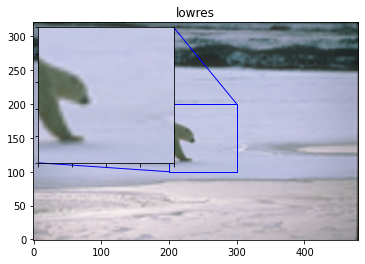

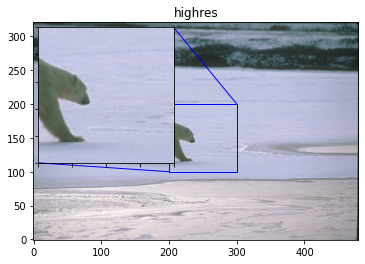

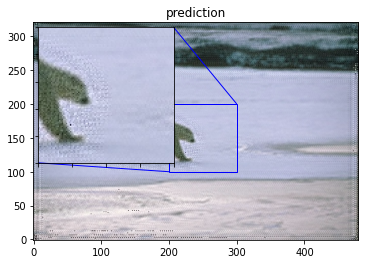

psmr_low: 30.381882136539197 psmr_pre: 24.76066109438897


In [15]:
main(model,'BSR/BSDS500/data/images/test/100007.jpg')

# 7.模型保存
将模型保存到 checkpoint/model_final ，并保留训练参数

In [16]:
model.save('checkpoint/model_final',training=True)